# Calculate some cross-correlations in time series

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import xarray as xr
from scipy.signal import correlate

In [3]:
#data_path = '/Users/raineyaberle/Research/Hubbard/'
data_path = '/Users/amyjenson/Documents/GitHub/Hubbard2024/make_paper_figures/'

figures_out_path = os.path.join(data_path, 'figures')

# Load velocity
v_fn = os.path.join(data_path, 'data', 'Hubbard_S1.nc')
v = xr.open_dataset(v_fn)
v = v.rio.write_crs('EPSG:3413')
v = v.rio.reproject('EPSG:3338') # reproject to Alaska Albers
v['v'] = np.sqrt(v['vx']**2 + v['vy']**2) 
# Convert units from m/yr to m/d
v = v / 365

# Load terminus and weather
term_fn = os.path.join(data_path, 'data', 'terminus_speed_weather.csv')
term = pd.read_csv(term_fn)
term['Date'] = pd.to_datetime(term['Date'])
term


,Date,AirTempC_Haenke1,AirTempC_Haenke2,AirTempC_Yakutat,Precip_Yakutat,PDD_Haenke1,PDD_Haenke2,PDD_Yakutat,AirTempC_Yakutat_smooth,surface_speed_m_per_yr,terminus_retreat_m,frontal_ablation_m_per_yr,retreat_rate_m_per_yr
0,2017-01-23,0.469565,-0.242391,1.515000,0.013208,0.469565,0.000000,1.515000,1.167000,2199.749740,357.220294,1863.516311,-240.967385
1,2017-01-24,1.056044,0.293407,2.425824,0.018034,1.056044,0.293407,2.425824,1.015031,2208.419088,356.532690,1874.671018,-238.021979
2,2017-01-25,1.608791,0.818681,NaN,NaN,1.608791,0.818681,NaN,0.862364,2217.088435,355.845086,1885.825725,-235.076572
3,2017-01-26,3.531868,2.836264,4.316461,0.017272,3.531868,2.836264,4.316461,0.709834,2225.757783,355.157482,1896.980431,-232.131166
4,2017-01-27,4.673913,4.034783,4.293488,0.017780,4.673913,4.034783,4.293488,0.556453,2234.427131,354.469878,1908.135138,-229.185760
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2146,2022-12-09,NaN,NaN,-4.850641,0.000254,NaN,NaN,0.000000,1.385443,678.508571,287.388602,1344.318601,691.254382
2147,2022-12-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.463263,694.344108,289.283163,1359.328730,691.466980
2148,2022-12-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.533238,710.179645,291.177725,1374.338858,691.679578
2149,2022-12-12,NaN,NaN,2.391813,0.016002,NaN,NaN,2.391813,1.565370,726.015182,293.072286,1389.348987,691.892176


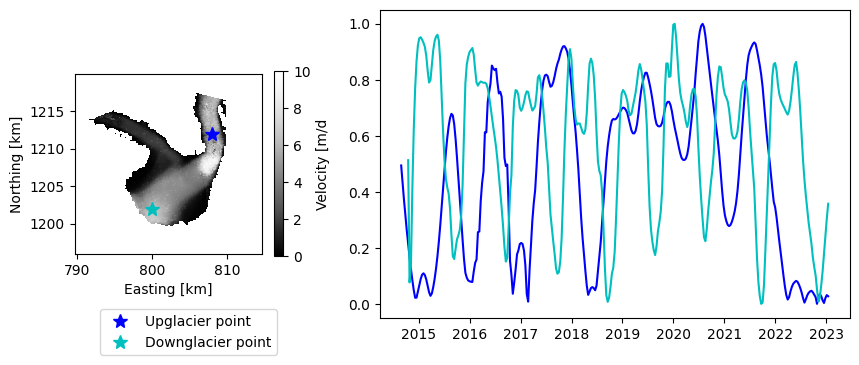

In [4]:
# Pick a couple points
p1 = [808e3, 1212e3]
p2 = [800e3, 1202e3]

# Calculate the mean at each point over time
v1 = v.sel(x=p1[0], y=p1[1], method='nearest')
v1 = xr.where(v1 > 15, np.nan, v1)
v2 = v.sel(x=p2[0], y=p2[1], method='nearest')
v2 = xr.where(v2 > 15, np.nan, v2)

# Normalize from 0 to 1
v1_norm =  (v1 - np.min(v1)) / (np.max(v1) - np.min(v1))
v2_norm =  (v2 - np.min(v2)) / (np.max(v2) - np.min(v2))

# Plot
fig, ax = plt.subplots(1, 2, figsize=(10,4), gridspec_kw={'width_ratios': [1, 2]})
ax = ax.flatten()
      
v_im = ax[0].imshow(v.mean(dim='time').v.data, cmap='Greys_r', clim=(0,10),
                    extent=(np.min(v.x.data)/1e3, np.max(v.x.data)/1e3, 
                            np.min(v.y.data)/1e3, np.max(v.y.data)/1e3))
ax[0].plot(p1[0]/1e3, p1[1]/1e3, '*b', markersize=10, label='Upglacier point')
ax[0].plot(p2[0]/1e3, p2[1]/1e3, '*c', markersize=10, label='Downglacier point')
ax[0].legend(loc='lower left', bbox_to_anchor=[0.1, -0.6, 0.2, 0.2])
fig.colorbar(v_im, ax=ax[0], shrink=0.6, label='Velocity [m/d')
ax[0].set_xlabel('Easting [km]')
ax[0].set_ylabel('Northing [km]')
ax[1].plot(v1.time.data, v1_norm.v.data, '-b')
ax[1].plot(v2.time.data, v2_norm.v.data, '-c')

plt.show()

## Combine all variables into dataframe

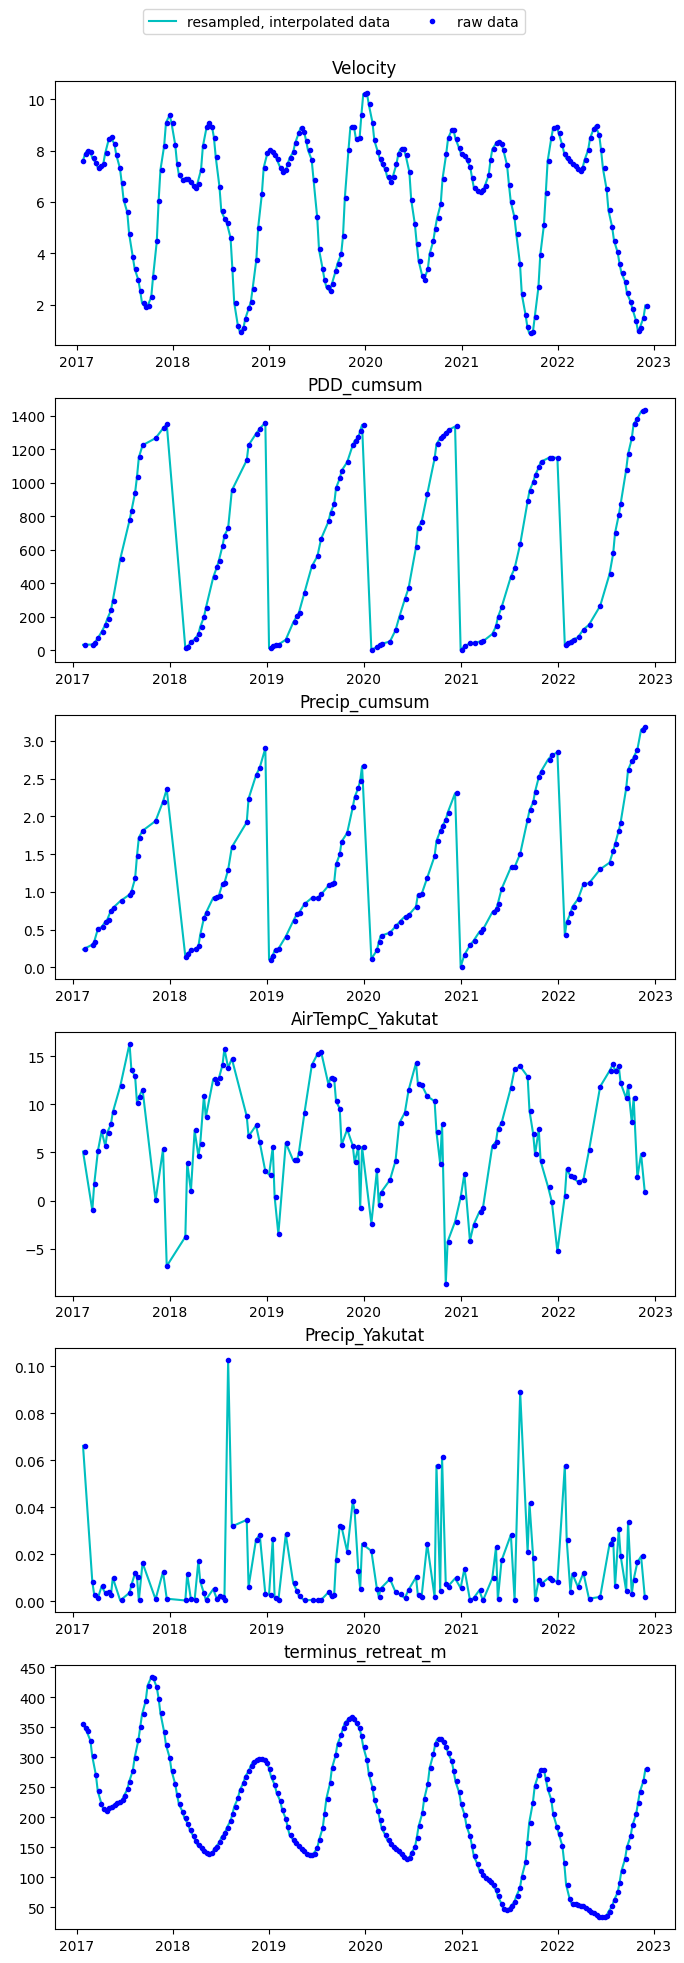

In [5]:
# velocity
v_df = pd.DataFrame({'Date': v2.time.data,
                     'Velocity': v2.v.data})

# add cumsum PDDs and precip for each year
term['PDD_cumsum'] = term.groupby(pd.DatetimeIndex(term['Date']).year)['PDD_Yakutat'].cumsum()
term['Precip_cumsum'] = term.groupby(pd.DatetimeIndex(term['Date']).year)['Precip_Yakutat'].cumsum()
# select relevant columns
term = term[['Date', 'PDD_cumsum', 'Precip_cumsum', 'AirTempC_Yakutat', 'Precip_Yakutat', 'terminus_retreat_m']]

# combine
data_df = v_df.merge(term, on='Date').set_index('Date')

# resample onto weekly time scale
data_resamp_df = data_df.resample(pd.Timedelta(1,'W')).mean()

# interpolate missing values
data_resamp_interp_df = data_resamp_df.interpolate(method='linear')

# plot
vars = list(data_df.columns)
fig, ax = plt.subplots(len(vars), 1, figsize=(8, 4*len(vars)))
for i, var in enumerate(vars):
    ax[i].plot(data_resamp_interp_df[var], '-c', label='resampled, interpolated data')
    ax[i].plot(data_df[var], '.b', label='raw data')
    ax[i].set_title(str(var))
    if i==0:
        ax[i].legend(loc='upper center', ncols=2, bbox_to_anchor=[0.35, 1.1, 0.2, 0.2])
plt.show()

## Calculate cross-correlation between all variables

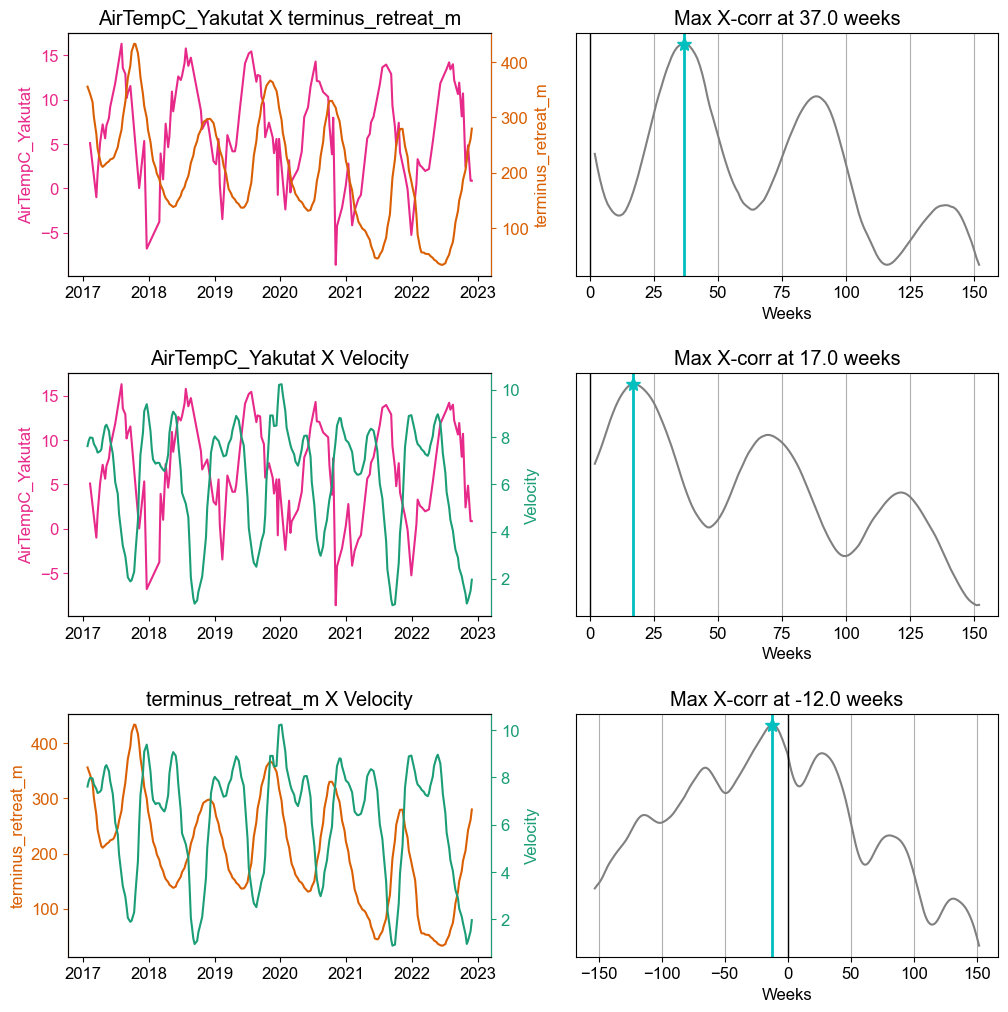

Figure saved to file: xcorr_velocity_terminus_weather.png


In [7]:
# Define variable combinations
combos = [['AirTempC_Yakutat', 'terminus_retreat_m'],
          ['AirTempC_Yakutat', 'Velocity'],
          ['terminus_retreat_m', 'Velocity']]

# Define dictionary of colors for plotting variables
colors_dict = {'Velocity': '#1b9e77',
               'terminus_retreat_m': '#d95f02',
               'Precip_Yakutat': '#7570b3',
               'AirTempC_Yakutat': '#e7298a'}

# Set up figure
plt.rcParams.update({'font.size': 12, 'font.sans-serif': 'Arial'})
fig, ax = plt.subplots(len(combos), 2, figsize=(12, 4*len(combos)))

# Iterate over each combination of data variables
icombo = 0
for i in range(len(combos)):
    # grab data variables
    var1 = combos[i][0]
    var2 = combos[i][1]
    x1 = data_resamp_interp_df[var1]
    x2 = data_resamp_interp_df[var2]
        
    # de-mean
    # x1 = x1 - x1.mean()
    # x2 = x2 - x2.mean()

    # calculate cross-correlation
    xcorr = correlate(x1, x2, mode='same')
    Imax = np.ravel(np.argwhere(xcorr==np.nanmax(xcorr)))[0]

    # grab colors for each
    x1_col = colors_dict[var1]
    x2_col = colors_dict[var2]
        
    # plot
    ax[icombo,0].plot(x1.index, x1.values, '-', color=x1_col, label=var1)
    ax[icombo,0].spines['left'].set_color(x1_col)
    ax[icombo,0].tick_params(axis='y', colors=x1_col)
    ax[icombo,0].set_ylabel(var1, color=x1_col)
    ax[icombo,0].set_title(f'{var1} X {var2}')
    ax2 = ax[icombo,0].twinx()
    ax2.plot(x2.index, x2.values, '-', color=x2_col, label=var2)
    ax2.spines['right'].set_color(x2_col)
    ax2.tick_params(axis='y', colors=x2_col)
    ax2.set_ylabel(var2, color=x2_col)
    weeks = np.arange(-(len(xcorr)/2), len(xcorr)/2)
    ax[icombo,1].plot(weeks, xcorr, '-', color='grey')
    ax[icombo,1].plot(weeks[Imax], xcorr[Imax], '*', color='c', markersize=10)
    ax[icombo,1].set_xlabel('Weeks')
    ax[icombo,1].axvline(0, linestyle='-', color='k', linewidth=1)
    ax[icombo,1].axvline(weeks[Imax], linestyle='-', color='c', linewidth=2)
    ax[icombo,1].set_title(f'Max X-corr at {weeks[Imax]} weeks')
    ax[icombo,1].set_yticks([])
    ax[icombo,1].grid()
    
    icombo+=1
    
fig.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

# save figure
fig_fn = os.path.join('xcorr_velocity_terminus_weather.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_fn)